In [1]:
import json
from Networks import ContentBasedLearn2RankNetwork_Evaluation
from utils import ground_truth_rank_indexes, auc_exact, load_embeddings_and_ids, plot_images
import tensorflow as tf

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [3]:
with open('./data/ugallery_AMT_train_test_5.json') as f:
    train_test_5 = json.load(f)

In [4]:
MODEL_PATH = ('/mnt/workspace/pamessina_models/ugallery/youtube_like/v16(10M-400K,avg+max,rsnt50'
              '+alxnt+incepv3,u(300,300,200)i(200,200),+p(rl&fk)-np,+npfavc(rl&fk)-nfavc,+nxt+hdaccklst-nfavc,fg.6,vcf.1/')
EMBEDDINGS_PATH = ('/mnt/workspace/Ugallery/Youtube-like/v16(10M-400K,avg+max,rsnt50'
              '+alxnt+incepv3,u(300,300,200)i(200,200),+p(rl&fk)-np,+npfavc(rl&fk)-nfavc,+nxt+hdaccklst-nfavc,fg.6,vcf.1/')

In [5]:
def get_aucs_and_topk_recommendations(embeddings_path, model_path, train_test_list, model_kwargs, K=100):
    youtube_like = load_embeddings_and_ids(embeddings_path, 'item_vectors.npy', 'ids')
    embeddings = youtube_like['featmat']
    artwork_ids = youtube_like['index2id']
    artwork_id2index = youtube_like['id2index']
    n_artworks = len(artwork_ids)
    all_indexes = list(range(n_artworks))    
    recommendations = []
    
    with tf.Graph().as_default():
        network = ContentBasedLearn2RankNetwork_Evaluation(**model_kwargs)
        with tf.Session() as sess:
            saver = tf.train.Saver()
            saver.restore(sess, tf.train.latest_checkpoint(model_path))
            aucs = []
            for row in train_test_list:
                train_indexes = [artwork_id2index[_id] for _id in row['train']]
                test_indexes_set = set(artwork_id2index[_id] for _id in row['test'])
                train_indexes_set = set(train_indexes)
                candidate_indexes = [i for i in all_indexes if i not in train_indexes_set]
                match_scores = network.get_match_scores(sess, embeddings, train_indexes, candidate_indexes)                
                tuples = [(s,i) for i,s in zip(candidate_indexes, match_scores)]                
                tuples.sort(reverse=True)
                ranked_candidate_indexes = [t[1] for t in tuples]                
                gt_indexes = ground_truth_rank_indexes(ranked_candidate_indexes, test_indexes_set)
                aucs.append(auc_exact(gt_indexes, len(candidate_indexes)))
                recommendations.append([artwork_ids[idx] for i, idx in enumerate(ranked_candidate_indexes) if i < K])                
            return aucs, recommendations

In [18]:
!ls /mnt/workspace/pamessina_models/ugallery/youtube_like/

checkpoint
v1
v10(10M-300K,avg+max,+prof(rl&fk)-nprof)
v11(10M-300K,avg+max,+prof(rl&fk)-nprof,+nproffavc(rl&fk)-nfavc_loc)
v12(10M-300K,avg+max,+prof(rl&fk)-nprof,+nxt+hide1+hideacc-nfavc_full)
v13(10M-300K,avg+max,resnet50+alexnet+inceptionv3,u(300,300,200),i(200,200),+prof(rl&fk)-nprof,+nproffavc(rl&fk)-nfavc,+nxt+hideaccklast-nfavc,finegrained=0.5)
v14(10M-300K,avg+max,rsnt50+alxnt+incpv3,u(300,300,200)i(200,200),+p(rl&fk)-np,+npfavc(rl&fk)-nfavc,+nxt+hdaccklst+hd1-nfavc,fg=.55)
v15(10M-400K,avg+max,rsnt50+alxnt+incpv3,u300_300_200,i_200_200,+p(r&f)-np,+npfavc(r&f)-nfavc,fgvc(f),+nxt+hdaccklst-nfavc,fg.6,vconf.2)
v16(10M-400K,avg+max,rsnt50+alxnt+incepv3,u(300,300,200)i(200,200),+p(rl&fk)-np,+npfavc(rl&fk)-nfavc,+nxt+hdaccklst-nfavc,fg.6,vcf.1
v2
v3_hidelast_usermodelbigger
v4_hidelast_usermodelbig
v5_usermodelbigger
v6_avgpool+maxpool
v7_avgpool+maxpool_prednextbasket
v8_avgpool+maxpool_prednextbasket_hideandpred
v9(10M-300K,avg+max,+prof(rl&fk)-nprof,+nproffavc(rl&fk)-nfavc_loc,+

In [6]:
aucs, recommendations = get_aucs_and_topk_recommendations(EMBEDDINGS_PATH, MODEL_PATH, train_test_5, model_kwargs=dict(
    user_layer_units=[300,300,200],
    latent_space_dim=200,
    profile_pooling_mode='AVG+MAX',
))

INFO:tensorflow:Restoring parameters from /mnt/workspace/pamessina_models/ugallery/youtube_like/v16(10M-400K,avg+max,rsnt50+alxnt+incepv3,u(300,300,200)i(200,200),+p(rl&fk)-np,+npfavc(rl&fk)-nfavc,+nxt+hdaccklst-nfavc,fg.6,vcf.1/


In [12]:
import matplotlib.pyplot as plt
image_cache = dict()
def visualize_recommendation(train_test, recommendations, aucs, index, topk=10):
    pairs = [(auc,i) for i,auc in enumerate(aucs)]
    pairs.sort(reverse=True)
    i = pairs[index][1]
    print("auc = %f" % pairs[index][0])
    print("-------- TRAINING (%d) ----------" % len(train_test[i]['train']))
    plot_images(plt, image_cache, train_test[i]['train'])
    print("-------- RECOMMENDATION (%d) ----------" % topk)
    plot_images(plt, image_cache, recommendations[i][:topk])
    print("-------- GROUND TRUTH (%d) ----------" % len(train_test[i]['test']))
    plot_images(plt, image_cache, train_test[i]['test'])

In [13]:
sum(aucs) / len(aucs)

0.5975162622617954

auc = 0.373658
-------- TRAINING (5) ----------


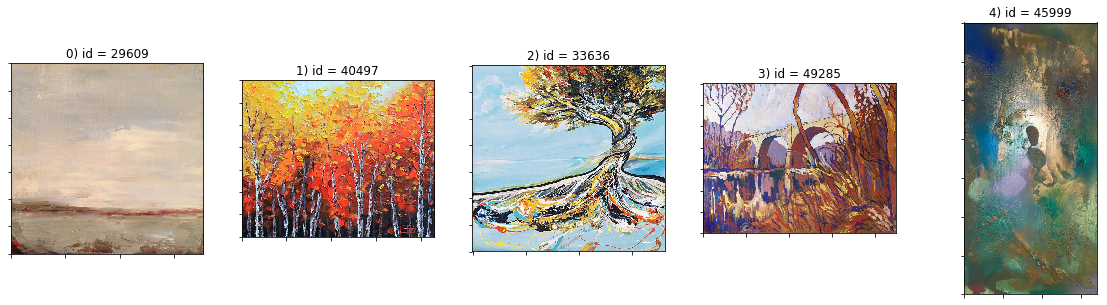

-------- RECOMMENDATION (20) ----------


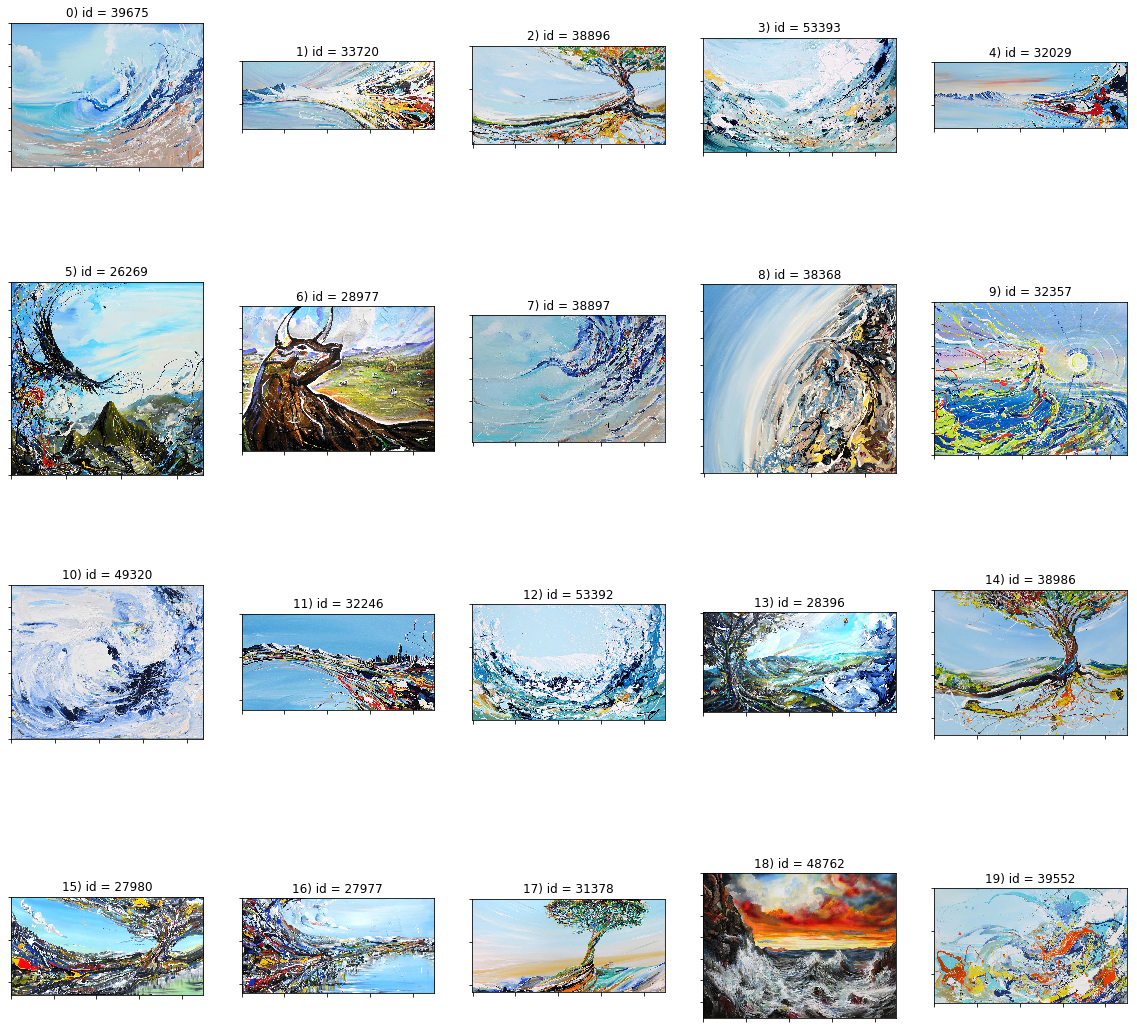

-------- GROUND TRUTH (5) ----------


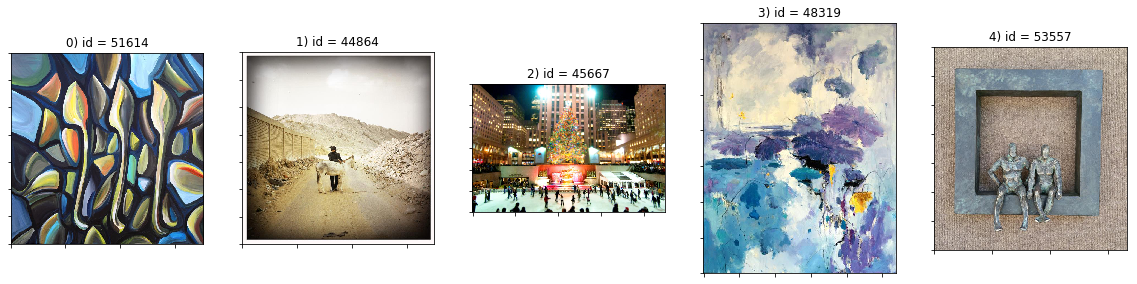

In [23]:
visualize_recommendation(train_test_5, recommendations, aucs, -20, topk=20)